# ML Model Selection for the Titanic Survivor Problem
## Creating a model to predict the survivors of the Titanic

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# Tidy data

raw_data = pd.read_csv('train.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# print(train_data.columns)

test_data['Survived'] = np.nan

data = pd.concat([train_data,test_data]).reset_index()

# Encode the Sex category
data['Male'] = data.Sex.apply(lambda x: 1 if x == 'male' else 0)
data['Female'] = data.Sex.apply(lambda x: 1 if x == 'female' else 0)
data.drop('Sex', axis=1, inplace=True)

# Encode Pclass
encoded_pclass = pd.get_dummies(data.Pclass, prefix='Pclass')
data = data.join(encoded_pclass)
data.drop('Pclass', axis=1, inplace=True)

# Extract Title from name - could be useful
data['Title'] = data.Name.apply(lambda x: x.split('.')[0].split(' ')[-1])


# Use Title as indication of Marriage Status
data['Married'] = data.Title.apply(lambda x: 'Y' if x in ['Mrs', 'Mr', 'Mme'] else ('N' if x in ['Miss', 'Master', 
                                                                                                 'Mlle'] else '?'))
# print(data.Married.value_counts())

encoded_married = pd.get_dummies(data.Married, prefix='Married')
data = data.join(encoded_married)
data.drop('Married', axis=1, inplace=True)


# I am going to fill in the people with NaN for age, using their title as an indication of age - i.e. NaN will be
## replaced with average age of people with the same title (e.g. Master and Miss usually refer to younger people)

title_vs_age = data.groupby('Title').Age.mean()

data.Age = data.apply(lambda row: title_vs_age[row.Title] if math.isnan(row.Age) else row.Age, axis=1)

# Remove 'Title' and 'Name' columns now used
data.drop(['Title', 'Name'],axis=1, inplace=True)

# Tidy ticket number and convert an integer - Massive skew on the data due to outliers >3,000,000, I will remove these 
## and assign these and the LINE values max ticket number +1 as these would have the final assigned tickets if they 
### weren't pre-booked

data.Ticket = data.Ticket.apply(lambda x: 3000001 if x == 'LINE' else int(x.split(' ')[-1]))

max_ticket = data.Ticket[data.Ticket<3000000].max()

data.Ticket = data.Ticket.apply(lambda x: max_ticket + 1 if (x == 'LINE' or x > 3000000) else x)


# Remove the Cabin data as 687 out of 891 entries are nan - this will not be useful for analysis

data.drop('Cabin', axis=1, inplace=True)


# I can't see any clues for the Embarked location of the passengers with NaN, so I will assign these to the largest
## group and then encode these
# print(data.Embarked.value_counts())
data.Embarked = data.Embarked.apply(lambda x: 'S' if type(x) == float else x)

encoded_E = pd.get_dummies(data.Embarked, prefix='Embarked')

data = data.join(encoded_E)

data.drop('Embarked', axis=1, inplace=True)

# 1 person has a Fare of NAN - replace with the median Fare

data.Fare = data.Fare.apply(lambda x: data.Fare.median() if pd.isna(x) == True else x)

# The fare seems to increase exponentially, so I will use natural log of Fare instead to get a more suitable scale
## I must add 1 to all values first to avoid an error as ln(0) is undefined

# data['ln_Fare'] = data.Fare.apply(lambda x: math.log(x+1))

data.Fare = data.Fare.apply(lambda x: 300 if x > 300 else x)

# data.drop('Fare', axis=1, inplace=True)




train_data = data.iloc[:891]
test_data = data.iloc[891:].drop(['Survived'], axis=1)

y = train_data['Survived']
X = train_data.drop(['Survived', 'PassengerId', 'index'], axis=1)

cols = X.columns


X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 10, train_size = 0.8)

# Standardise all data

ct = ColumnTransformer([('scale',StandardScaler(),['Age','SibSp','Parch','Ticket','Fare'])], remainder='passthrough')

X_train = pd.DataFrame(ct.fit_transform(X_train), columns=cols)
X_train.index = y_train.index

X_val = pd.DataFrame(ct.transform(X_val), columns=cols)
X_val.index = y_val.index

print(X_train.head())


          Age     SibSp     Parch    Ticket      Fare  Male  Female  Pclass_1  \
57  -0.090091 -0.458505 -0.477849 -1.025489 -0.554353   1.0     0.0       0.0   
717 -0.203449 -0.458505 -0.477849 -0.823754 -0.480805   0.0     1.0       0.0   
431  0.551829  0.412044 -0.477849  1.367268 -0.354883   0.0     1.0       0.0   
633  0.193468 -0.458505 -0.477849 -0.325615 -0.716909   1.0     0.0       1.0   
163 -0.959171 -0.458505 -0.477849  0.973853 -0.522123   1.0     0.0       0.0   

     Pclass_2  Pclass_3  Married_?  Married_N  Married_Y  Embarked_C  \
57        0.0       1.0        0.0        0.0        1.0         1.0   
717       1.0       0.0        0.0        1.0        0.0         0.0   
431       0.0       1.0        0.0        0.0        1.0         0.0   
633       0.0       0.0        0.0        0.0        1.0         0.0   
163       0.0       1.0        0.0        0.0        1.0         0.0   

     Embarked_Q  Embarked_S  
57          0.0         0.0  
717         0.0     

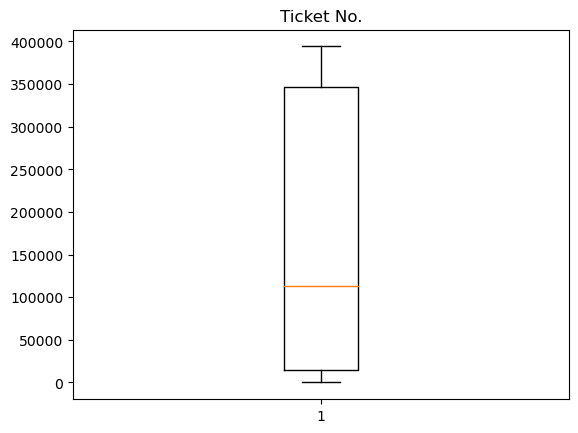

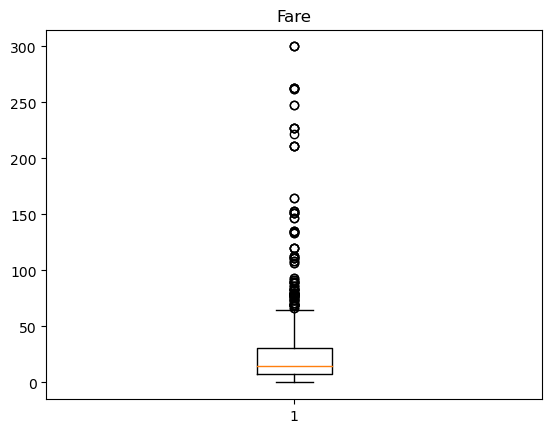

In [3]:
# Investigate the Data
plt.close()
plt.figure()
plt.title('Ticket No.')
plt.boxplot(X.Ticket)
plt.show()


plt.figure()
plt.title('Fare')
plt.boxplot(X.Fare)
plt.show()



In [4]:
# Coarse Model Selection

model_pipeline = Pipeline([('lda', LinearDiscriminantAnalysis()), ('clf', SVC())])

model_param_1 = {'lda': [LinearDiscriminantAnalysis(), None], 'clf': [SVC()], 
                 'clf__kernel': ['poly', 'rbf'], 'clf__degree': [2, 3, 4]}

model_param_2 = {'lda': [LinearDiscriminantAnalysis(), None], 'clf': [KNeighborsClassifier()], 
                 'clf__n_neighbors': list(range(4, 11))}

model_param_3 = {'lda': [LinearDiscriminantAnalysis(), None], 'clf': [RandomForestClassifier()], 
                 'clf__max_depth': list(range(5, 16))}

model_param_4 = {'lda': [LinearDiscriminantAnalysis(), None], 'clf': [LogisticRegression()], 
                 'clf__solver': ['lbfgs', 'liblinear', 'newton-cg']}

model_param_grid = [model_param_1, model_param_2, model_param_3, model_param_4]

model_grid = GridSearchCV(model_pipeline, model_param_grid, cv=5, verbose=1, error_score='raise', scoring='accuracy')

model_grid.fit(X_train, y_train)

print(model_grid.best_estimator_)

print(model_grid.best_estimator_.score(X_val, y_val))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/BenPollins/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/BenPollins/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

/Users/BenPollins/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/BenPollins/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

/Users/BenPollins/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/BenPollins/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

/Users/BenPollins/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/BenPollins/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

Pipeline(steps=[('lda', None), ('clf', RandomForestClassifier(max_depth=8))])
0.8659217877094972


In [5]:
# Feature Selection

base_pipeline = model_grid.best_estimator_
scores = []
features = []

# print(base_pipeline)

for x in range(len(X.columns)-3,len(X.columns)):
    sbs = SFS(base_pipeline, n_features_to_select=x, direction='forward', scoring=None, cv=10)

    sbs.fit(X_train, y_train)

    selected_features = [X_train.columns[i] for i in sbs.get_support(indices=True)]

    X_train_reduced = X_train[selected_features]

    X_val_reduced = X_val[selected_features]

    base_pipeline.fit(X_train_reduced, y_train)
    
    print(f'{x} Features:')
    print(base_pipeline.score(X_val_reduced, y_val))
    
    scores.append(base_pipeline.score(X_val_reduced, y_val))
    features.append(selected_features)

base_pipeline.fit(X_train, y_train)

print(f'{len(X.columns)} Features:')
print(base_pipeline.score(X_val, y_val))

if max(scores) > base_pipeline.score(X_val, y_val):
    selected_features = features[scores.index(max(scores))]

else:
    selected_features = X_train.columns

X_train_reduced = X_train[selected_features]
X_val_reduced = X_val[selected_features]


13 Features:
0.8324022346368715
14 Features:
0.8659217877094972
15 Features:
0.8770949720670391
16 Features:
0.8659217877094972


In [6]:
print(selected_features)

['Age', 'SibSp', 'Ticket', 'Fare', 'Male', 'Female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Married_?', 'Married_N', 'Married_Y', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


In [7]:
# Model Fine-Tuning

fine_tune_params = {'clf__max_depth': list(range(base_pipeline['clf'].max_depth-2, base_pipeline['clf'].max_depth+3)),
                   'clf__criterion': ['gini', 'entropy'], 'clf__n_estimators': [100, 200, 300, 400], 
                    'clf__class_weight': [None, 'balanced', 'balanced_subsample'], 'clf__random_state':[1]}

fine_tune_grid = GridSearchCV(base_pipeline, fine_tune_params, cv=10, verbose=1, scoring='accuracy')


fine_tune_grid.fit(X_train_reduced, y_train)


tuned_model = fine_tune_grid.best_estimator_

print(tuned_model)


print('Training:')
print(tuned_model.score(X_train_reduced, y_train))
print('Validation:')
print(tuned_model.score(X_val_reduced, y_val))

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Pipeline(steps=[('lda', None),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=7,
                                        random_state=1))])
Training:
0.9030898876404494
Validation:
0.8603351955307262


/var/folders/0t/cn_67kmx2bx1dd485f_b4pgm0000gn/T/ipykernel_10883/1187278617.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_X['add'] = incorrect_X.Age
/var/folders/0t/cn_67kmx2bx1dd485f_b4pgm0000gn/T/ipykernel_10883/1187278617.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_X['add'] = correct_X.Age


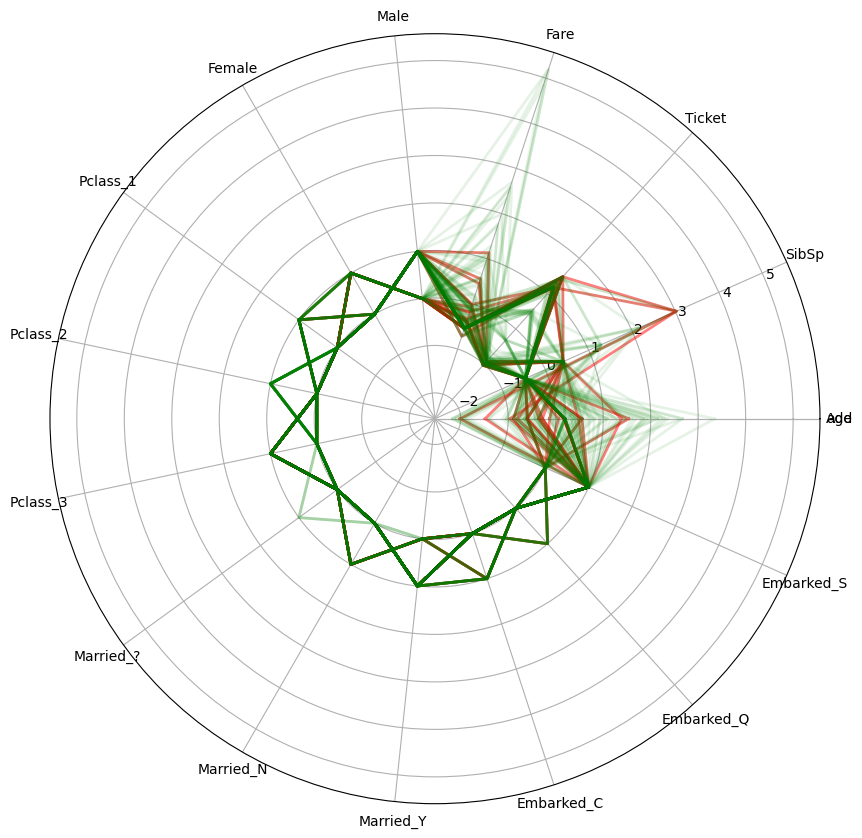

In [8]:
# Trying to spot a pattern in the incorrect guesses

y_predicted = pd.DataFrame(tuned_model.predict(X_val_reduced))
y_predicted.index = X_val.index

y_predicted = y_predicted.join(y_val)

y_predicted.columns = ['Prediction', 'Survived']

incorrect_y = y_predicted[y_predicted.Prediction != y_predicted.Survived]

incorrect_X = X_val_reduced[X_val_reduced.index.isin(incorrect_y.index)]

correct_y = y_predicted[y_predicted.Prediction == y_predicted.Survived]

correct_X = X_val_reduced[X_val_reduced.index.isin(correct_y.index)]
 

# Radial

incorrect_X['add'] = incorrect_X.Age
correct_X['add'] = correct_X.Age


label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(incorrect_X.columns))

fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(polar=True))

for i in range(len(incorrect_X)):   

    ax.plot(label_loc, incorrect_X.iloc[i], lw=2, color='r', alpha=0.5)

    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=incorrect_X.columns)
    
for i in range(len(correct_X)):   

    ax.plot(label_loc, correct_X.iloc[i], lw=2, color='g', alpha=0.1)

lines, labels = plt.thetagrids(np.degrees(label_loc), labels=correct_X.columns)

plt.show()


In [9]:
# Predict outcomes
total_train_data = pd.concat([X_train_reduced, X_val_reduced])
total_train_results = pd.concat([y_train,y_val])

tuned_model.fit(total_train_data, total_train_results)

test_data_reduced = test_data[selected_features]

predictions = pd.DataFrame()

predictions['PassengerId'] = test_data.PassengerId
predictions['Survived'] = tuned_model.predict(test_data_reduced).astype('int')

print(predictions)

predictions.to_csv('predictions.csv', index=False)


      PassengerId  Survived
891           892         0
892           893         0
893           894         0
894           895         0
895           896         0
...           ...       ...
1304         1305         0
1305         1306         1
1306         1307         0
1307         1308         0
1308         1309         0

[418 rows x 2 columns]
